In [204]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from datetime import datetime
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [205]:
# Specify the directory where the images are located
folder = "2024-06-16"
image_dir = f"data/{folder}"

# Get a list of all image files in the directory and its subdirectories
image_files = glob.glob(os.path.join(image_dir, '**/*.jpg'), recursive=True) + glob.glob(os.path.join(image_dir, '**/*.png'), recursive=True)

# Sort the image files
image_files = sorted(image_files)

# Print the list of image files
print(image_files)

['data/2024-06-16/2024-06-16-06/2024-06-16-06-00.jpg', 'data/2024-06-16/2024-06-16-06/2024-06-16-06-01.jpg', 'data/2024-06-16/2024-06-16-06/2024-06-16-06-02.jpg', 'data/2024-06-16/2024-06-16-06/2024-06-16-06-03.jpg', 'data/2024-06-16/2024-06-16-06/2024-06-16-06-04.jpg', 'data/2024-06-16/2024-06-16-06/2024-06-16-06-05.jpg', 'data/2024-06-16/2024-06-16-06/2024-06-16-06-06.jpg', 'data/2024-06-16/2024-06-16-06/2024-06-16-06-07.jpg', 'data/2024-06-16/2024-06-16-06/2024-06-16-06-08.jpg', 'data/2024-06-16/2024-06-16-06/2024-06-16-06-09.jpg', 'data/2024-06-16/2024-06-16-06/2024-06-16-06-10.jpg', 'data/2024-06-16/2024-06-16-06/2024-06-16-06-11.jpg', 'data/2024-06-16/2024-06-16-06/2024-06-16-06-12.jpg', 'data/2024-06-16/2024-06-16-06/2024-06-16-06-13.jpg', 'data/2024-06-16/2024-06-16-06/2024-06-16-06-14.jpg', 'data/2024-06-16/2024-06-16-06/2024-06-16-06-15.jpg', 'data/2024-06-16/2024-06-16-06/2024-06-16-06-16.jpg', 'data/2024-06-16/2024-06-16-06/2024-06-16-06-17.jpg', 'data/2024-06-16/2024-06-16

In [206]:
def calculate_mean_gray(image_path):
    # Load the image in grayscale mode
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Calculate and return the mean gray value
    return np.mean(img)

In [207]:
def diff_to_color_gradient_filter(img1, img2, threshold=0):
    # Calculate the difference
    diff = img2.astype(int) - img1.astype(int)

    # Create an empty color image
    color_img = np.zeros((*img1.shape, 3), dtype=np.uint8)

    # Set the red channel to the positive differences above the threshold
    color_img[(diff > threshold), 0] = diff[diff > threshold]

    # Set the green channel to the negative differences below the negative threshold
    color_img[(diff < -threshold), 1] = -diff[diff < -threshold]

    # Set the blue channel to the zero differences and differences within the threshold
    color_img[(diff == 0) | ((diff > -threshold) & (diff < threshold)), 2] = 0

    return color_img


In [208]:
mean_gray_values = [calculate_mean_gray(image_file) for image_file in image_files]
names = [os.path.basename(f) for f in image_files]
dates = [datetime.strptime(os.path.basename(f).split('.')[0], '%Y-%m-%d-%H-%M').isoformat() for f in image_files]

data = pd.DataFrame({
    'name': names,
    'date': dates,
    'mean_gray_value': mean_gray_values,
    'path': image_files
})

data = data.sort_values(by='name')

In [209]:
# Initialize lists to store the total red and green values and the compared_with values
total_red = []
total_green = []
compared_with = []
compared_with_path = []

# Initialize a variable to store the previous image and its path
prev_img = None
prev_img_path = None

threshold = 20  # Set your threshold value here

# Iterate over the image paths
for img_path in image_files:
    # Read the current image as grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # If there is a previous image, calculate the difference and the total red and green values
    if prev_img is not None:
        prev_img = cv2.imread(prev_img_path, cv2.IMREAD_GRAYSCALE)
        diff_color_img = diff_to_color_gradient_filter(img, prev_img, threshold=threshold)
        total_red.append(np.sum(diff_color_img[:,:,0]))
        total_green.append(np.sum(diff_color_img[:,:,1]))  # This will be the same as total_red for grayscale images
        compared_with.append(os.path.basename(prev_img_path))
        compared_with_path.append(prev_img_path)
    else:
        # If there is no previous image, append None to the total red and green values and the compared_with values
        total_red.append(None)
        total_green.append(None)
        compared_with.append(None)
        compared_with_path.append(None)
    
    # Update the previous image and its path
    prev_img = img
    prev_img_path = img_path

# Add the total red and green values and the compared_with values to the data as new columns
data['total_red'] = total_red
data['total_green'] = total_green
data['compared_with'] = compared_with
data['compared_with_path'] = compared_with_path

# Create a new column that is the sum of 'total_red' and 'total_green'
data['total_red_green'] = data['total_red'] + data['total_green']

# Sort the data by 'total_red_green' in descending order
data.sort_values(by='total_red_green', ascending=False, inplace=True)

## Check the shift of color values over time

In [225]:
# Red is decrease in reflection, green is increase, blue is no change


def diff_to_color_gradient(img1, img2):
    # Calculate the difference
    diff = img2.astype(int) - img1.astype(int)

    # Create an empty color image
    color_img = np.zeros((*img1.shape, 3), dtype=np.uint8)

    # Set the red channel to the positive differences
    color_img[diff > 0, 0] = diff[diff > 0]

    # Set the green channel to the negative differences
    color_img[diff < 0, 1] = -diff[diff < 0]

    # Set the blue channel to the zero differences
    color_img[diff == 0, 2] = 0

    return color_img


def diff_to_color(img1, img2, threshold=0):
    # Calculate the difference
    diff = img2.astype(int) - img1.astype(int)

    # Create an empty color image
    color_img = np.zeros((*img1.shape, 3), dtype=np.uint8)

    # Set the red channel to 255 (100% red) where the pixel value has decreased (darkened) below the negative threshold
    color_img[diff < -threshold, 1] = 255

    # Set the green channel to 255 (100% green) where the pixel value has increased above the threshold
    color_img[diff > threshold, 0] = 255

    # Set the blue channel to 255 (100% blue) for the zero differences and differences within the threshold
    color_img[(diff == 0) | ((diff > -threshold) & (diff < threshold)), 2] = 255

    return color_img

In [234]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 720 entries, 166 to 0
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                720 non-null    object 
 1   date                720 non-null    object 
 2   mean_gray_value     720 non-null    float64
 3   path                720 non-null    object 
 4   total_red           719 non-null    float64
 5   total_green         719 non-null    float64
 6   compared_with       719 non-null    object 
 7   compared_with_path  719 non-null    object 
 8   total_red_green     719 non-null    float64
dtypes: float64(4), object(5)
memory usage: 56.2+ KB


In [221]:
data.head()

,name,date,mean_gray_value,path,total_red,total_green,compared_with,compared_with_path,total_red_green
166,2024-06-16-08-46.jpg,2024-06-16T08:46:00,25.087828,data/2024-06-16/2024-06-16-08/2024-06-16-08-46.jpg,98366.0,122918.0,2024-06-16-08-45.jpg,data/2024-06-16/2024-06-16-08/2024-06-16-08-45.jpg,221284.0
165,2024-06-16-08-45.jpg,2024-06-16T08:45:00,25.074253,data/2024-06-16/2024-06-16-08/2024-06-16-08-45.jpg,48119.0,81326.0,2024-06-16-08-44.jpg,data/2024-06-16/2024-06-16-08/2024-06-16-08-44.jpg,129445.0
164,2024-06-16-08-44.jpg,2024-06-16T08:44:00,25.027316,data/2024-06-16/2024-06-16-08/2024-06-16-08-44.jpg,22578.0,56855.0,2024-06-16-08-43.jpg,data/2024-06-16/2024-06-16-08/2024-06-16-08-43.jpg,79433.0
187,2024-06-16-09-07.jpg,2024-06-16T09:07:00,24.877368,data/2024-06-16/2024-06-16-09/2024-06-16-09-07.jpg,46212.0,28078.0,2024-06-16-09-06.jpg,data/2024-06-16/2024-06-16-09/2024-06-16-09-06.jpg,74290.0
183,2024-06-16-09-03.jpg,2024-06-16T09:03:00,24.955346,data/2024-06-16/2024-06-16-09/2024-06-16-09-03.jpg,27155.0,44700.0,2024-06-16-09-02.jpg,data/2024-06-16/2024-06-16-09/2024-06-16-09-02.jpg,71855.0


In [222]:
cleaned_data = data.dropna()

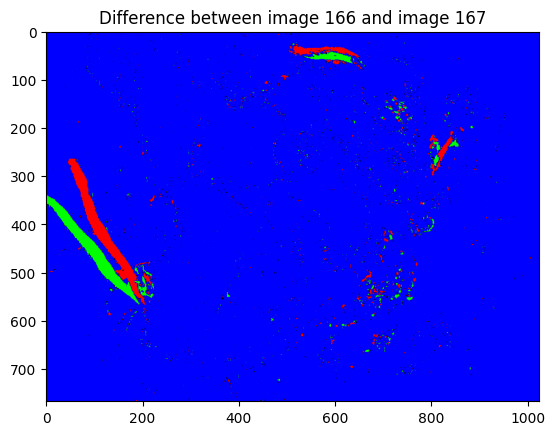

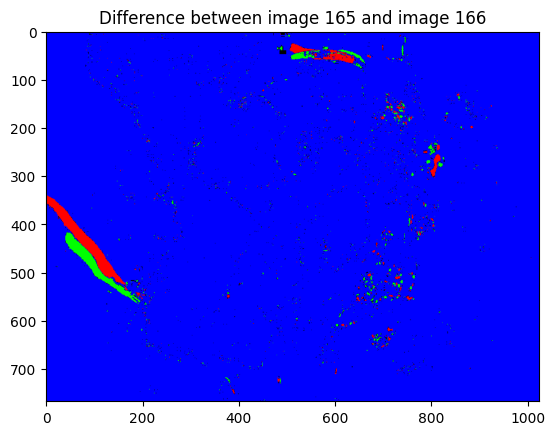

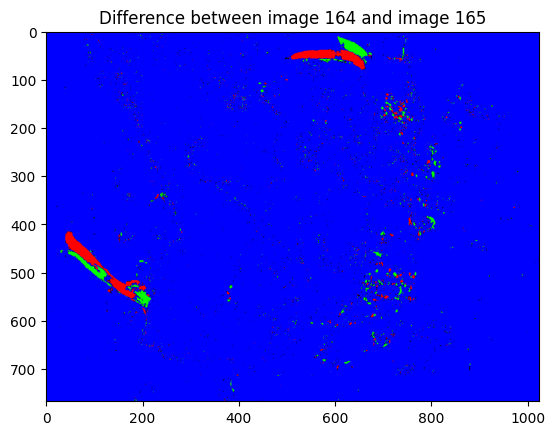

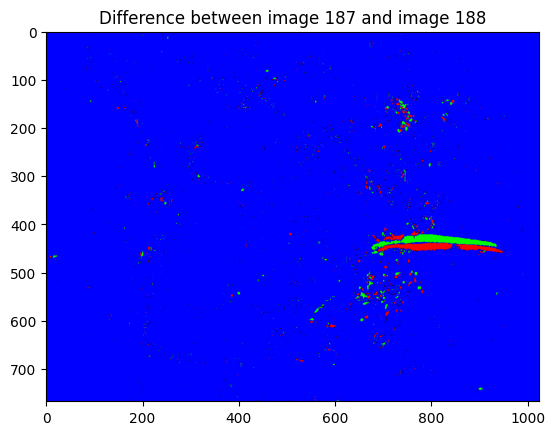

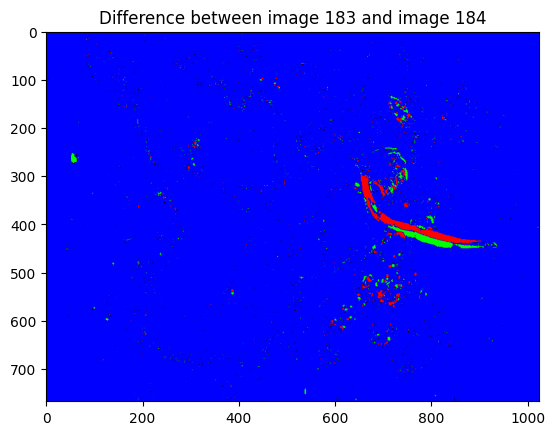

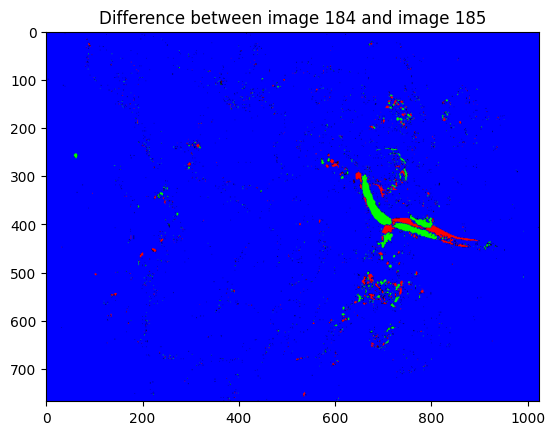

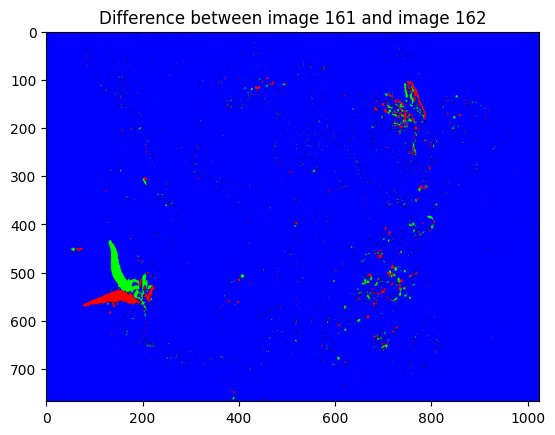

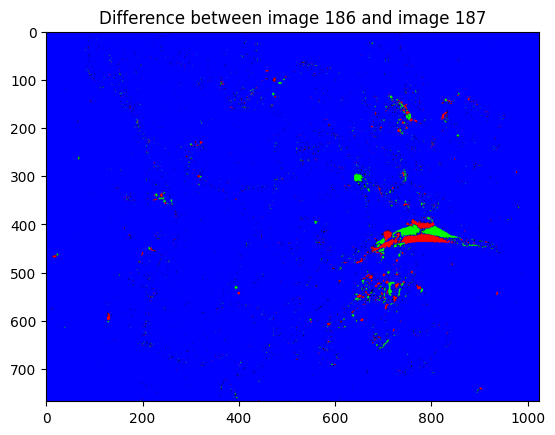

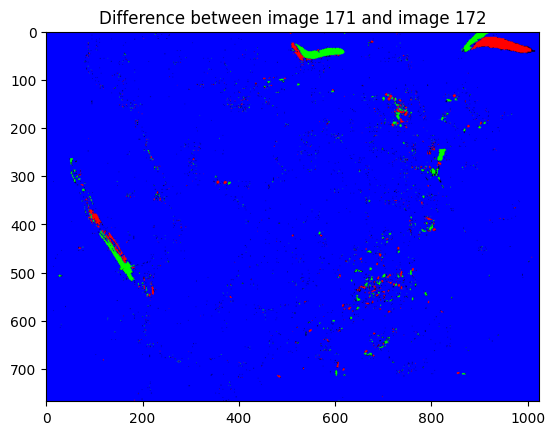

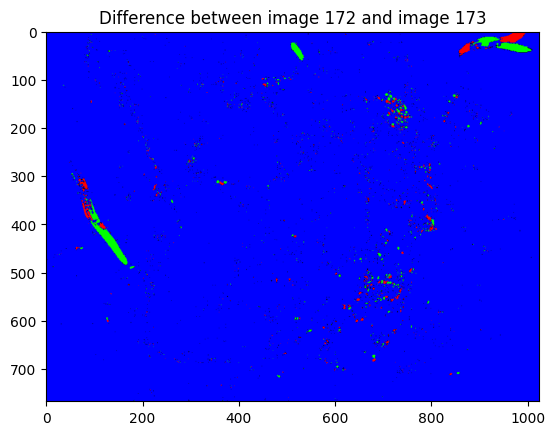

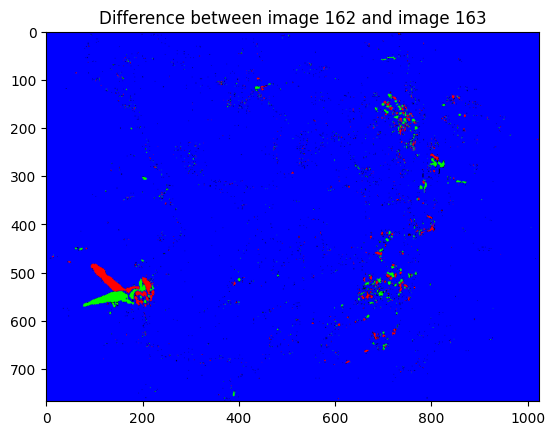

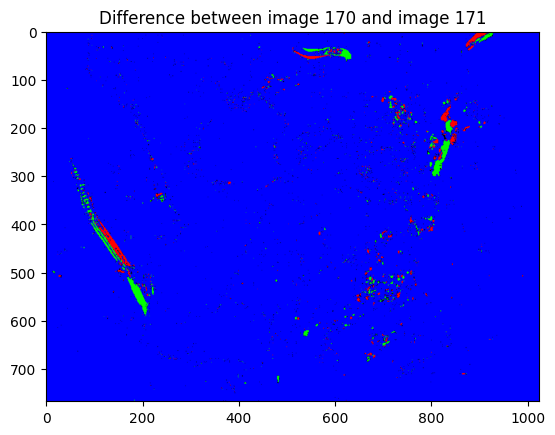

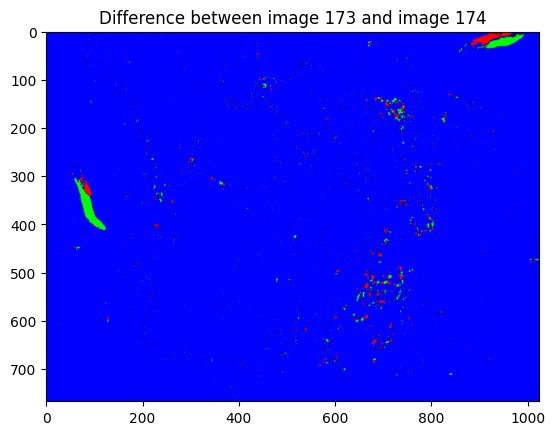

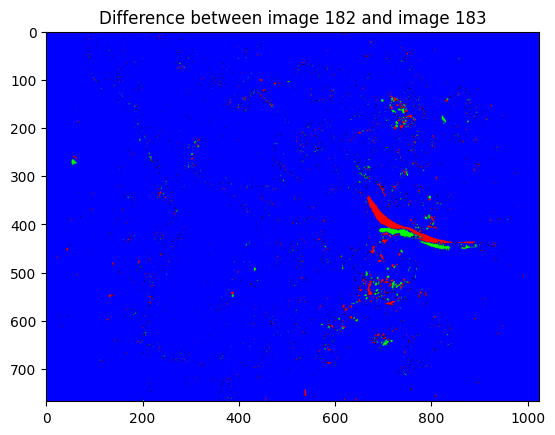

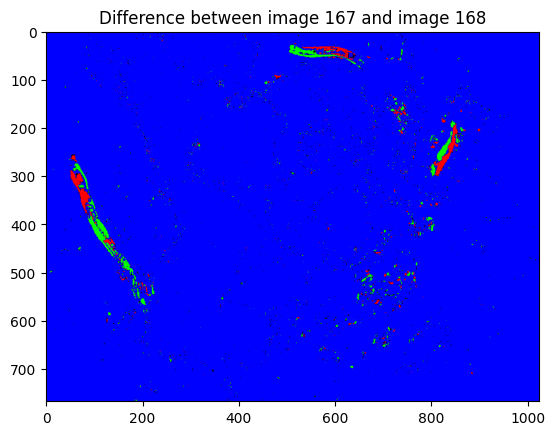

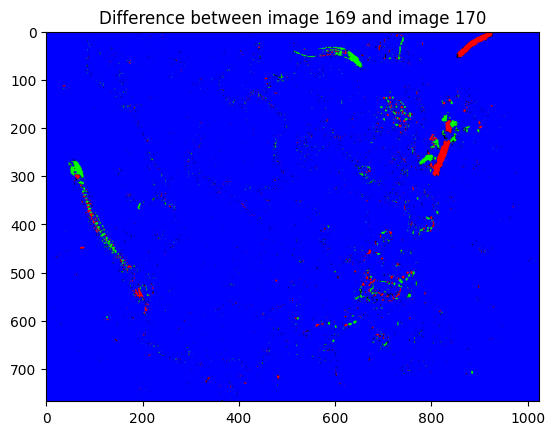

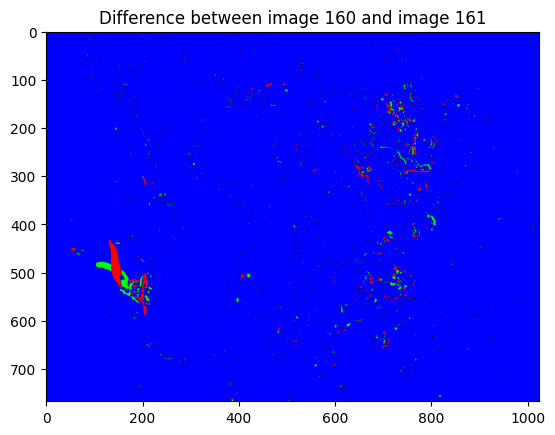

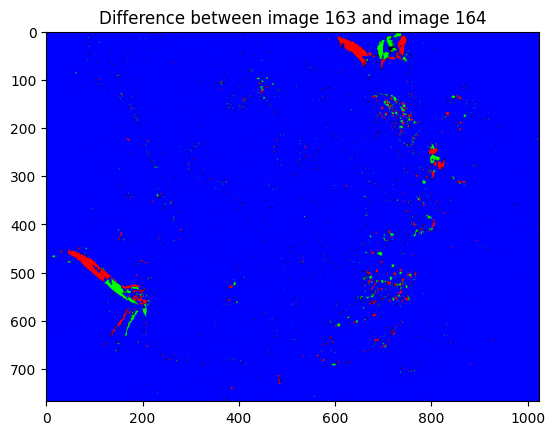

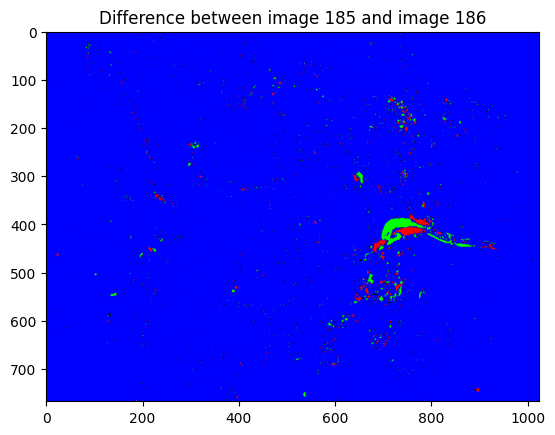

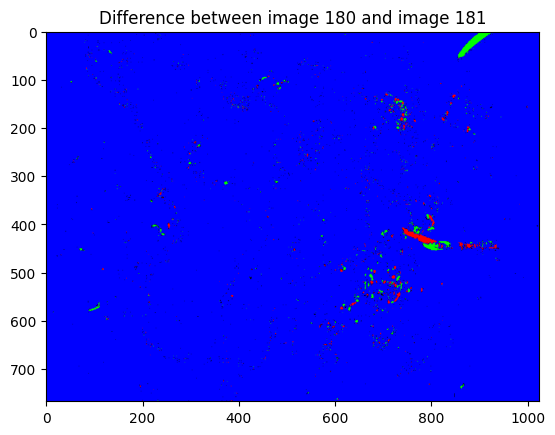

In [259]:
# Display each difference
for index, row in cleaned_data.head(20).iterrows():
    image_after = cv2.imread(row['path'], cv2.IMREAD_GRAYSCALE)
    image_before = cv2.imread(row['compared_with_path'], cv2.IMREAD_GRAYSCALE)
    color_diff = diff_to_color(image_before, image_after, threshold=5)
    # color_diff = diff_to_color_gradient_filter(image_before, image_after, threshold=0)
    plt.figure()
    plt.imshow(color_diff, cmap='gray')
    plt.title(f'Difference between image {index} and image {index+1}')
    plt.show()

In [250]:
pd.set_option('display.max_colwidth', None)
print(data.head(1)['path'])
print(data.head(1)['compared_with_path'])

166    data/2024-06-16/2024-06-16-08/2024-06-16-08-46.jpg
Name: path, dtype: object
166    data/2024-06-16/2024-06-16-08/2024-06-16-08-45.jpg
Name: compared_with_path, dtype: object


In [253]:
data[0:1]['path']

166    data/2024-06-16/2024-06-16-08/2024-06-16-08-46.jpg
Name: path, dtype: object

In [254]:
# large worms in image
# worm_no_yet_visible_path = glob.glob(os.path.join(image_dir, f'**/2024-06-16-08-45.jpg'), recursive=True)[0]
# worm_visible_path = glob.glob(os.path.join(image_dir, f'**/2024-06-16-08-46.jpg'), recursive=True)[0]

# no large worms in image
# worm_no_yet_visible_path = glob.glob(os.path.join(image_dir, f'**/2024-06-16-06-00.jpg'), recursive=True)[0]
# worm_visible_path = glob.glob(os.path.join(image_dir, f'**/2024-06-16-06-01.jpg'), recursive=True)[0]

# winner because of noise
worm_no_yet_visible_path = data.iloc[0]['path']
worm_visible_path = data.iloc[0]['compared_with_path']

worm_no_yet_visible = cv2.imread(worm_no_yet_visible_path, cv2.IMREAD_GRAYSCALE)
worm_visible = cv2.imread(worm_visible_path, cv2.IMREAD_GRAYSCALE)

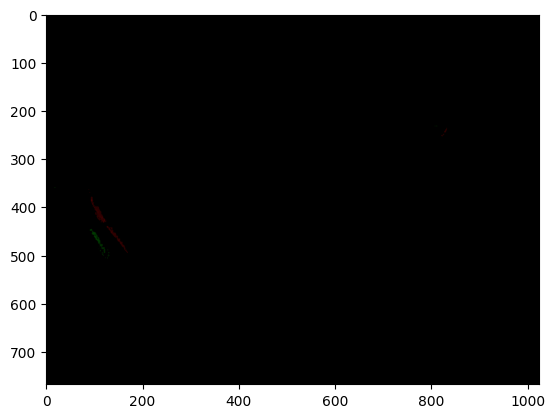

In [255]:
diff_img = diff_to_color_gradient_filter(worm_visible, worm_no_yet_visible, threshold=39)

plt.imshow(diff_img)
plt.show()

51816


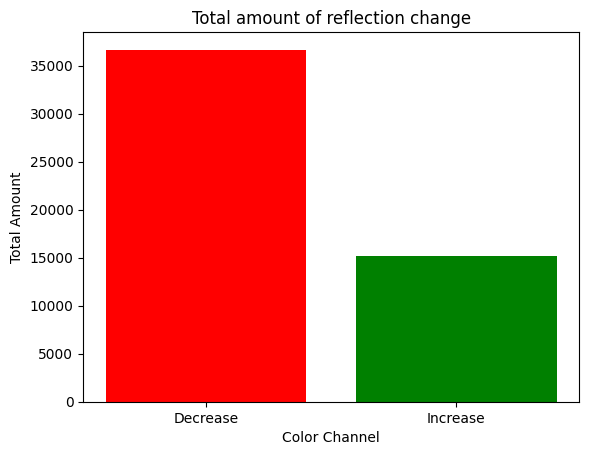

In [256]:
# Calculate the total amount of each color channel
total_red = np.sum(diff_img[:, :, 0])
total_green = np.sum(diff_img[:, :, 1])

print(total_red + total_green)

# Plot the total amounts
plt.bar(['Decrease', 'Increase'], [total_red, total_green], color=['red', 'green'])
plt.title('Total amount of reflection change')
plt.xlabel('Color Channel')
plt.ylabel('Total Amount')
plt.show()